# Prévisions météo en Australie

# Modélisation sans étape de ré-échantillonage

# Récupération des librairies

In [1]:
# récupération du package scikit-plot
!pip install scikit-plot

In [2]:
# récupération des librairies
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time, datetime
import scikitplot as skplt
import warnings
warnings.filterwarnings("ignore")

from scipy.spatial.distance import cdist
from scipy.stats import chi2_contingency

from sklearn import ensemble, linear_model, model_selection, neighbors, preprocessing, svm

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier, Lasso, LassoCV, lasso_path, RidgeCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, mean_squared_error, recall_score, f1_score, precision_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, learning_curve, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from imblearn.metrics import classification_report_imbalanced
from imblearn.under_sampling import RandomUnderSampler

# Modèles de classification par apprentissage supervisé

In [3]:
# récuperation et aperçu du jeu de données après prétraitement, après l'étape de classification des villes en fonction 
# du climat et après sélection des variables les plus pertinentes selon la méthode SelectKBest()
df = pd.read_csv('data/weatherAUS_preprocessed.csv', index_col=0)
df.head()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid,RainTomorrow
0,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,9.5,-49.0,1,0,0,0,0
1,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,17.7,-19.0,1,0,0,0,0
2,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,12.8,-8.0,1,0,0,0,0
3,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,18.8,-29.0,1,0,0,0,0
4,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,14.8,-49.0,1,0,0,0,0


In [4]:
# séparation des données en une matrice de données et en un vecteur cible
data = df.drop('RainTomorrow', axis=1)
target = df['RainTomorrow']

In [5]:
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=123)

In [6]:
# distribution de la variable cible dans l'ensemble d'entraînement
print("Cardinalité des classes de la variable cible dans l'ensemble d'entraînement:", 
      dict(pd.Series(y_train).value_counts()))

Cardinalité des classes de la variable cible dans l'ensemble d'entraînement: {0: 87624, 1: 25005}


In [7]:
# distribution de la variable cible dans l'ensemble d'entraînement
y_train.value_counts(normalize=True)

0    0.777988
1    0.222012
Name: RainTomorrow, dtype: float64

In [8]:
# distribution de la variable cible dans l'ensemble de test
print("Cardinalité des classes de la variable cible dans l'ensemble de test:", 
      dict(pd.Series(y_test).value_counts()))

Cardinalité des classes de la variable cible dans l'ensemble de test: {0: 21962, 1: 6196}


In [9]:
# distribution de la variable cible dans l'ensemble de test
y_test.value_counts(normalize=True)

0    0.779956
1    0.220044
Name: RainTomorrow, dtype: float64

In [10]:
# paramètre à initialiser pour calculer les performances des algorithmes avec ré-échantillonage
# param_ru = 'over_sample_rOs'
# param_ru = 'over_sample_smo'
# param_ru = 'under_sample_rUs'
# param_ru = 'under_sample_cc'
param_ru = ''

In [11]:
# standardisation des données
scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Régression Logistique

In [10]:
# définition du modèle
clf_lr = LogisticRegression()

# param_grid_lr = {'solver':['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'], 
#                  'C':np.linspace(0.1,1,10)}

param_grid_lr = {'solver':['liblinear'], 
                 'C':np.linspace(0.1,1,10)}

gcv_lr = GridSearchCV(clf_lr, param_grid_lr, cv=3)

In [11]:
start_time = time.time()

# entraînement
gcv_lr.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_lr.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_lr.best_params_, "\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_lr.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_lr.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print('\n', classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'C': 0.5, 'solver': 'liblinear'} 

Accuracy Score: 0.8439519852262235 

Train Data Score: 0.8398725017535448
Test Data Score: 0.8439519852262235

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            20742  1220
1             3174  3022

               precision    recall  f1-score   support

           0       0.87      0.94      0.90     21962
           1       0.71      0.49      0.58      6196

    accuracy                           0.84     28158
   macro avg       0.79      0.72      0.74     28158
weighted avg       0.83      0.84      0.83     28158

Running Time: 0:00:08.094185


- la méthode de régression logistique ne fait pas l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.49.
- la spécificité (taux de vrais négatifs) vaut 0.94.
- le F1-score concernant la classe '0' de la variable RainTomorrow est bon (0.90).
- le F1-score concernant la classe '1' de la variable RainTomorrow est faible (0.58).

In [12]:
cv_scores = cross_val_score(gcv_lr, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.83970381 0.83863836 0.84180806]
Average cross-validation score: 0.8400500759129531


- Le score de la méthode de régression logistique est en moyenne de : 0.84.

In [13]:
# sauvegarde des scores dans un fichier de sortie
pd.DataFrame([f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)],
             index=['f1','recall','precision'], 
             columns=['scores_clf_lr_' + param_ru]).to_csv('scores/scores_clf_lr_' + param_ru + '.csv')

In [14]:
# courbe ROC (Receiver Operating Characteristic) pour le modèle de régression logistique
y_pred_logreg_proba = gcv_lr.predict_proba(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_logreg_proba[:,1])

In [15]:
# aire sous la courbe ROC
roc_auc = auc(fpr, tpr)
print("Aire sous la courbe =", roc_auc)

Aire sous la courbe = 0.8574127304460215


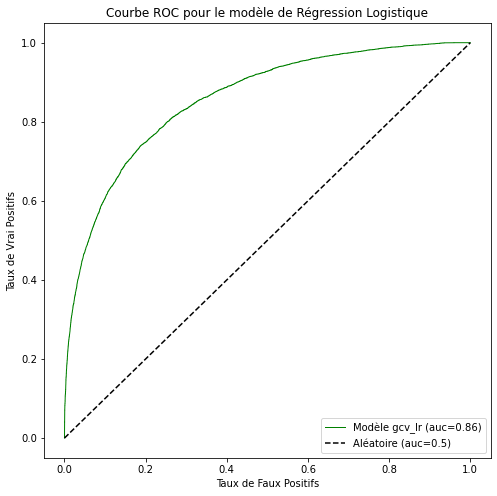

In [16]:
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, '-g', linewidth=1, label='Modèle gcv_lr (auc=%0.2f)' %roc_auc)
plt.plot([0,1], [0,1], 'k--', label='Aléatoire (auc=0.5)')
plt.title('Courbe ROC pour le modèle de Régression Logistique')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrai Positifs')
plt.legend(loc="lower right");


- La courbe ROC est l'outil idéal pour résumer la performance d'un classifieur binaire en fonction de tous les seuils possibles. Elle évite un long travail de prédictions de classes pour différents seuils, et d'évaluation de la matrice de confusion pour chacun de ces seuils.
- Graphiquement, la mesure ROC est représentée sous la forme d'une courbe qui donne le taux de vrais positifs (la sensibilité), en fonction du taux de faux positifs (l'antispécificité).
- Plus la courbe se rapproche du point (0,1), meilleures sont les prédictions. Un modèle avec une sensibilité et une spécificité égales à 1 est considéré comme parfait.



## Forêts Aléatoires

In [17]:
# définition du modèle
clf_rf  = RandomForestClassifier() # les forêts aléatoires ne gèrent pas les variables qualitatives

param_grid_rf  = [{'n_estimators' : [50, 100, 150],
                   'min_samples_leaf' : np.arange(1,6,1),
                   'max_features' : ['sqrt', 'log2']}]

gcv_rf = GridSearchCV(clf_rf, param_grid_rf)

In [18]:
start_time = time.time()

# entraînement
gcv_rf.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_rf.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_rf.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_rf.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_rf.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print(classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 150} 

Accuracy Score: 0.8557070814688543 

Train Data Score: 0.9401930231112768
Test Data Score: 0.8557070814688543

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            20997   965
1             3098  3098
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     21962
           1       0.76      0.50      0.60      6196

    accuracy                           0.86     28158
   macro avg       0.82      0.73      0.76     28158
weighted avg       0.85      0.86      0.84     28158

Running Time: 0:28:16.399215


- la méthode de forêt aléatoire fait l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.50.
- la spécificité (taux de vrais négatifs) vaut 0.96.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.91).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.60).

In [19]:
cv_scores = cross_val_score(gcv_rf, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.84963908 0.84995871 0.85259569]
Average cross-validation score: 0.8507311616013639


- Le score de la méthode des forêts aléatoires est en moyenne de : 0.85.

In [20]:
# sauvegarde des scores dans un fichier de sortie
pd.DataFrame([f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)],
             index=['f1','recall','precision'], 
             columns=['scores_clf_rf_' + param_ru]).to_csv('scores/scores_clf_rf_' + param_ru + '.csv')

In [21]:
# probabilités pour X_test_scaled d'appartenir à chacune des deux classes
y_probas = gcv_rf.predict_proba(X_test_scaled)

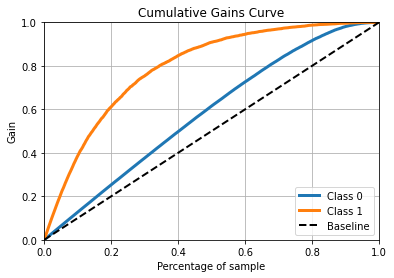

In [22]:
# courbe de gain cumulée
skplt.metrics.plot_cumulative_gain(y_test, y_probas);

- L'axe horizontal représente les individus de l'échantillon test.
- L'axe vertical représente la variable cible "RainTomorrow".

## Séparateurs à Vaste Marge (SVM)

Les séparateurs à vaste marge (SVM) visent à résoudre les problèmes de classification en trouvant de bonnes frontières de décision entre deux ensembles de points appartenant à deux catégories différentes. Une frontière de décision peut être considérée comme une ligne ou une surface séparant les données d’apprentissage en deux demi-espaces correspondant à deux catégories de prédiction, soit dans le cadre de notre étude **"RainTomorrow=0"** et **"RainTomorrow=1"**. Pour classer de nouveaux points de données, il suffit de vérifier de quel côté de la frontière de décision ils se trouvent.

Les séparateurs à vaste marge procèdent à la recherche de ces frontières en deux étapes :
- Les données sont mises en correspondance avec une nouvelle représentation à haute dimension où la frontière de décision peut être exprimée sous la forme d’un hyperplan.
- Le séparateur à vaste marge identifie l'hyperplan qui maximise la distance au point le plus proche dans chaque classe. Cela permet à la frontière de bien s’adapter à de nouveaux échantillons en dehors de l’ensemble de données d’apprentissage.

La méthode de classification par SVM ne fournit pas directement de probabilités d'appartenir à chaque classe mais les classes prédites elle-mêmes en fonction du score qu'elle attribuent à chaque individu. 

In [12]:
# définition du modèle: création d'un objet SVC (Support Vector Classificator)
clf_svm = svm.SVC(class_weight={0:2, 1:1})

param_grid_svm = {'kernel':['rbf'], 'gamma':[0.5]}

gcv_svm = GridSearchCV(estimator=clf_svm, param_grid=param_grid_svm, scoring='accuracy')

In [13]:
start_time = time.time()

# entraînement
grille = gcv_svm.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_svm.predict(X_test_scaled)

# affichage des meilleurs paramètres de la grille pour le modèle "gcv_svm"
print('Meilleurs paramètres :', gcv_svm.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_svm.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_svm.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print(classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'gamma': 0.5, 'kernel': 'rbf'} 

Accuracy Score: 0.8473258043895163 

Train Data Score: 0.8648039137344734
Test Data Score: 0.8473258043895163

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            21536   426
1             3873  2323
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     21962
           1       0.85      0.37      0.52      6196

    accuracy                           0.85     28158
   macro avg       0.85      0.68      0.71     28158
weighted avg       0.85      0.85      0.82     28158

Running Time: 2:53:31.058194


- la méthode SVM fait l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.37.
- la spécificité (taux de vrais négatifs) vaut 0.98.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.91).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.52).

In [14]:
cv_scores = cross_val_score(gcv_svm, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.83941081 0.84079589 0.84210106]
Average cross-validation score: 0.8407692512585568


- Le score de la méthode SVM est en moyenne de : 0.84.

In [15]:
# affichage des combinaisons possibles d'hyperparamètres 
# et de la performance moyenne du modèle associé par validation croisée
print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params','mean_test_score']])

                            params  mean_test_score
0  {'gamma': 0.5, 'kernel': 'rbf'}         0.841631


In [16]:
# construction de la courbe ROC (Receiver Operating Characteristic)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [17]:
# calcul de l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)
print("Aire sous la courbe: ", roc_auc)

Aire sous la courbe:  0.6777610811302744


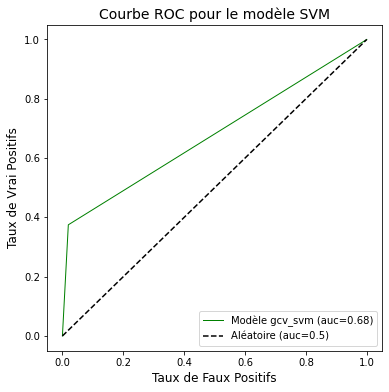

In [18]:
# affichage de la courbe ROC
fig = plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, '-g', linewidth=1, label='Modèle gcv_svm (auc=%.2f)' %roc_auc)
plt.plot([0,1], [0,1], 'k--', label='Aléatoire (auc=0.5)')
plt.title('Courbe ROC pour le modèle SVM', fontsize=14)
plt.xlabel('Taux de Faux Positifs', fontsize=12)
plt.ylabel('Taux de Vrai Positifs', fontsize=12)
plt.legend(loc="lower right", fontsize=10);

In [19]:
# sauvegarde des scores dans un fichier de sortie
pd.DataFrame([f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)],
             index=['f1','recall','precision'], 
             columns=['scores_clf_svm_' + param_ru]).to_csv('scores/scores_clf_svm_' + param_ru + '.csv')

## K-plus proches voisins

In [29]:
# définition du modèle
clf_knn = neighbors.KNeighborsClassifier()

param_grid_knn = {'n_neighbors' : np.arange(20,41,1),
                  'metric' : ['minkowski','manhattan','chebyshev']}

gcv_knn = GridSearchCV(clf_knn, param_grid_knn)

In [30]:
start_time = time.time()

# entraînement
gcv_knn.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_knn.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_knn.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_knn.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_knn.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print(classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'metric': 'manhattan', 'n_neighbors': 31} 

Accuracy Score: 0.8528659705945024 

Train Data Score: 0.8553036962061281
Test Data Score: 0.8528659705945024

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            20968   994
1             3149  3047
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     21962
           1       0.75      0.49      0.60      6196

    accuracy                           0.85     28158
   macro avg       0.81      0.72      0.75     28158
weighted avg       0.84      0.85      0.84     28158

Running Time: 2:06:51.817811


- la méthode des K-plus proches voisins ne fait pas l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.49.
- la spécificité (taux de vrais négatifs) vaut 0.95.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.91).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.60).

In [33]:
# cv_scores = cross_val_score(gcv_knn, X_train_scaled, y_train, cv=3, scoring='accuracy')

# print('Cross-validation scores:{}'.format(cv_scores))
# print('Average cross-validation score: {}'.format(cv_scores.mean()))

- Le score de la méthode KNN est en moyenne de : XXX.

In [34]:
# sauvegarde des scores dans un fichier de sortie
pd.DataFrame([f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)],
             index=['f1','recall','precision'], 
             columns=['scores_clf_knn_' + param_ru]).to_csv('scores/scores_clf_knn_' + param_ru + '.csv')

In [35]:
# scores de 3 modèles utilisant respectivement les matrices de Minkowski, Manhattan et Chebyshev 
# pour des valeurs de k allant de 1 à 40
score_minko = []
score_man = []
score_cheb = []

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_scaled, y_train)
  score_minko.append(knn.score(X_test_scaled, y_test))

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='manhattan')
  knn.fit(X_train_scaled, y_train)
  score_man.append(knn.score(X_test_scaled, y_test))

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
  knn.fit(X_train_scaled, y_train)
  score_cheb.append(knn.score(X_test_scaled, y_test))

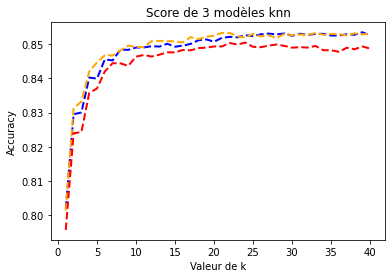

In [36]:
# affichage des listes crées en fonction de k
plt.title("Score de 3 modèles knn")
plt.plot(range(1,41), score_minko, color='blue', linestyle='dashed', lw=2, label='Minkowski')
plt.plot(range(1,41), score_man, color='orange', linestyle='dashed', lw=2, label='Manhattan')
plt.plot(range(1,41), score_cheb, color='red', linestyle='dashed', lw=2, label='Chebyshev')
plt.xlabel("Valeur de k")
plt.ylabel("Accuracy")
plt.legend;

## Arbres de décision

In [37]:
# définition du modèle
clf_dt = DecisionTreeClassifier()

param_grid_dt = {'criterion' : ['entropy','gini'], 
                 'max_depth' : np.arange(2,6,1)}

gcv_dt = GridSearchCV(clf_dt, param_grid_dt)

In [38]:
start_time = time.time()

# entraînement
gcv_dt.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_dt.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_dt.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_dt.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_dt.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print(classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'criterion': 'gini', 'max_depth': 5} 

Accuracy Score: 0.839193124511684 

Train Data Score: 0.8386028465137754
Test Data Score: 0.839193124511684

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            20825  1137
1             3391  2805
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     21962
           1       0.71      0.45      0.55      6196

    accuracy                           0.84     28158
   macro avg       0.79      0.70      0.73     28158
weighted avg       0.83      0.84      0.83     28158

Running Time: 0:00:05.701137


- la méthode des arbres de décision ne fait pas l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.45.
- la spécificité (taux de vrais négatifs) vaut 0.95.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.90).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.55).

In [39]:
# importance des variables
clf_dt = gcv_dt.best_estimator_
clf_dt.fit(X_train_scaled,y_train)

feats = {}
for feature, importance in zip(df.columns, clf_dt.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0:'Importance'})
importances.sort_values(by='Importance', ascending=False).head(8)

,Importance
Humidity3pm,0.750954
WindGustSpeed,0.086579
Rainfall,0.058749
Sunshine,0.047818
Pressure9am,0.046689
clim_méditerranéen,0.003083
Humidity_Delta,0.002374
clim_chaud_humide,0.001898


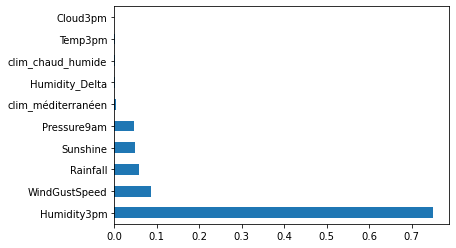

In [40]:
# importance des variables
feature_imp = pd.Series(clf_dt.feature_importances_,index=data.columns)
feature_imp.nlargest(10).plot(kind='barh');

In [41]:
cv_scores = cross_val_score(gcv_dt, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.83514903 0.83714674 0.83829209]
Average cross-validation score: 0.8368626197515737


- Le score de la méthode DT est en moyenne de : 0.84.

In [42]:
pd.DataFrame([f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)],
             index=['f1','recall','precision'], 
             columns=['scores_clf_dt_' + param_ru]).to_csv('scores/scores_clf_dt_' + param_ru + '.csv')

# Résumé des performances

In [23]:
scores_clf_dt_ = pd.read_csv('scores/scores_clf_dt_.csv', index_col=0)
scores_clf_knn_ = pd.read_csv('scores/scores_clf_knn_.csv', index_col=0)
scores_clf_svm_ = pd.read_csv('scores/scores_clf_svm_.csv', index_col=0)
scores_clf_rf_ = pd.read_csv('scores/scores_clf_rf_.csv', index_col=0)
scores_clf_lr_ = pd.read_csv('scores/scores_clf_lr_.csv', index_col=0)

In [24]:
result_ = pd.concat([scores_clf_dt_, scores_clf_knn_, scores_clf_svm_, scores_clf_rf_, scores_clf_lr_], axis=1)

In [25]:
result_

,scores_clf_dt_,scores_clf_knn_,scores_clf_svm_,scores_clf_rf_,scores_clf_lr_
f1,0.553364,0.595292,0.519396,0.603958,0.579038
recall,0.452711,0.491769,0.374919,0.500000,0.487734
precision,0.711568,0.754021,0.845035,0.762491,0.712400
